Topic: Maryland Housing Model

Personal Project

Garrett Fanning

# Introduction

# Data Description

## Source

https://www.census.gov/programs-surveys/popest/data/tables.html
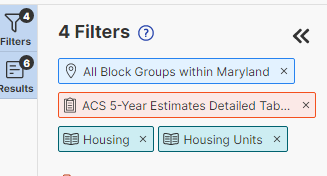

https://data.census.gov/cedsci/

## Feature Breakdown

**Housing** - Number of houses in a block
<br> **Population** - Population in a block
<br> **Earnings** - Per capita earnings in a block (past 12 months adjusted in 2020 inflation adjusted dollars)
<br> **Poverty** - Number living in poverty(based on Census income threshold) in a block
<br> **Employment** - Number of people in labor force in a block
<br> **Elders** - Number of households with someone over 60
<br> **Rooms** - Median number of rooms per house in a block
<br> **Children** - Number of children in school in a block
<br> **HouseType** - Vacant houses in a block
<br> **Age** - Median Age of a block
<br> **Transportation** - Number of people with less than a 10 minute commute
<br> **HousePrice** - Median price of a home in a block
<br> **School** - Number of schools in a block

# Libraries

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle
import os
import flask
from flask import Flask, redirect, url_for,request, render_template
import math

## Creating Functions

In [2]:
#Read the file in for each feature across all years available
def read_house(fileName, list_of_years):
    all_years = pd.DataFrame()
    a_dictionary = {}
    for year in list_of_years:
        filepath = fileName+'_'+year+'.csv'
        a_dictionary["%s %s" % (fileName,year)] = pd.read_csv(filepath)
        temp = pd.DataFrame.from_dict(a_dictionary["%s %s" % (fileName,year)])
        temp['Year'] = year
        all_years = pd.concat([all_years,temp])
    return all_years
    
def clean_house(original_file, feature, code):
    #Eliminate unecessary column label row
    new_file = original_file.loc[original_file[code].str.isnumeric() & original_file[code].notna()]
    #Narrow to only columns needed
    new_file = new_file[[code,"GEO_ID","NAME","Year"]]
    #Rename Columns
    new_file = new_file.rename(columns = {code:feature,"GEO_ID":"GEO_ID","NAME":"Name","Year":"Year"})
    #Convert string column to float
    new_file[feature] = new_file[feature].astype(float)
    #Do not include rows/each 'Block' with 0
    new_file = new_file.loc[(new_file[feature]>0)]
    #Sort by increasing
    new_file = new_file.sort_values(by = feature)
    return new_file
    
#Issues with Rooms data requires separate method be created
def clean_house_room(original_file, feature, code):
    #Eliminate unecessary column label row
    new_file = original_file.loc[(original_file[code].notna()) & -(original_file[code].str.contains('!') | original_file[code].str.contains('9.0+')| original_file[code].str.contains('-'))]
    #Narrow to only columns needed
    new_file = new_file[[code,"GEO_ID","NAME","Year"]]
    #Rename Columns
    new_file = new_file.rename(columns = {code:feature,"GEO_ID":"GEO_ID","NAME":"Name","Year":"Year"})
    #Convert string column to float
    new_file[feature] = new_file[feature].astype(float)
    #Do not include rows/each 'Block' with 0
    new_file = new_file.loc[(new_file[feature]>0)]
    #Sort by increasing
    new_file = new_file.sort_values(by = feature)
    return new_file


# Read Data In

## Maryland Housing Data

In [3]:
#first part of data source file name
fileName = 'Maryland_Housing'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Housing_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Units'
#code of feature before being renamed
code = 'B25001_001E'
#run clean_house method in House object
Maryland_Housing = clean_house(Maryland_Housing_Original, feature, code)
print('Records by year:\n' , Maryland_Housing['Year'].value_counts())
Maryland_Housing

Records by year:
 2020    4027
2019    3894
2014    3894
2017    3894
2015    3893
2013    3892
2016    3892
2018    3891
Name: Year, dtype: int64


Units                 GEO_ID  \
3731     3.0  1500000US245102606056   
3731     3.0  1500000US245102606056   
889      3.0  1500000US240054925002   
946      3.0  1500000US240054925002   
365      4.0  1500000US240039800001   
...      ...                    ...   
3229  5341.0  1500000US240479501002   
3229  5603.0  1500000US240479501002   
3412  5627.0  1500000US240479501002   
3229  5688.0  1500000US240479501002   
3229  5717.0  1500000US240479501002   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2016  
889   Block Group 2, Census Tract 4925, Baltimore Co...  2015  
946   Block Group 2, Census Tract 4925, Baltimore Co...  2020  
365   Block Group 1, Census Tract 9800, Anne Arundel...  2014  
...                                                 ...   ...  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2016  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2017  
3412  Block Group 2, Census Tract 9501, Worcester Co...  2020  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2018  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2019  

[31277 rows x 4 columns]

## Maryland Population Data

In [4]:
#first part of data source file name
fileName = 'Maryland_Population'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Population_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Population'
#code of feature before being renamed
code = 'B01003_001E'
#run clean_house method in House object
Maryland_Population = clean_house(Maryland_Population_Original, feature, code)
print('Records by year:\n' , Maryland_Population['Year'].value_counts())
Maryland_Population

Records by year:
 2020    4036
2017    3904
2018    3903
2019    3903
2015    3902
2016    3902
2014    3902
2013    3901
Name: Year, dtype: int64


Population                 GEO_ID  \
3731         3.0  1500000US245102606056   
3731         3.0  1500000US245102606056   
3731         4.0  1500000US245102606056   
3717         5.0  1500000US245102604041   
3717         5.0  1500000US245102604041   
...          ...                    ...   
1174      8211.0  1500000US240178509041   
1805      8236.0  1500000US240317002051   
1174      8739.0  1500000US240178509041   
1805      8987.0  1500000US240317002051   
3082     13709.0  1500000US240339800001   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2016  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2015  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2015  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2016  
...                                                 ...   ...  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2018  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2018  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2019  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2019  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  

[31353 rows x 4 columns]

## Maryland Earnings Data

In [5]:
#first part of data source file name
fileName = 'Maryland_Earnings'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Earnings_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Earnings'
#code of feature before being renamed
code = 'B19301_001E'
#run clean_house method in House object
Maryland_Earnings = clean_house(Maryland_Earnings_Original, feature, code)
print('Records by year:\n' , Maryland_Earnings['Year'].value_counts())
Maryland_Earnings

Records by year:
 2020    4027
2018    3899
2013    3898
2019    3898
2017    3898
2015    3897
2016    3897
2014    3897
Name: Year, dtype: int64


Earnings                 GEO_ID  \
890       73.0  1500000US240054926001   
890      166.0  1500000US240054926001   
890      187.0  1500000US240054926001   
890      191.0  1500000US240054926001   
3406     230.0  1500000US245101202021   
...        ...                    ...   
2319  227096.0  1500000US240317045021   
2354  230545.0  1500000US240317055011   
2350  232858.0  1500000US240317053001   
2501  241917.0  1500000US240317056021   
3773  320631.0  1500000US245102201003   

                                                   Name  Year  
890   Block Group 1, Census Tract 4926, Baltimore Co...  2014  
890   Block Group 1, Census Tract 4926, Baltimore Co...  2015  
890   Block Group 1, Census Tract 4926, Baltimore Co...  2016  
890   Block Group 1, Census Tract 4926, Baltimore Co...  2017  
3406  Block Group 1, Census Tract 1202.02, Baltimore...  2017  
...                                                 ...   ...  
2319  Block Group 1, Census Tract 7045.02, Montgomer...  2013  
2354  Block Group 1, Census Tract 7055.01, Montgomer...  2019  
2350  Block Group 1, Census Tract 7053, Montgomery C...  2013  
2501  Block Group 1, Census Tract 7056.02, Montgomer...  2020  
3773  Block Group 3, Census Tract 2201, Baltimore ci...  2020  

[31311 rows x 4 columns]

## Maryland Elders

In [7]:
#first part of data source file name
fileName = 'Maryland_Elders'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Elders_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Elders'
#code of feature before being renamed
code = 'B11006_002E'
#run clean_house method in House object
Maryland_Elders = clean_house(Maryland_Elders_Original, feature, code)
print('Records by year:\n' , Maryland_Elders['Year'].value_counts())
Maryland_Elders

Records by year:
 2020    4003
2018    3873
2019    3873
2015    3872
2016    3872
2013    3871
2014    3869
2017    3867
Name: Year, dtype: int64


Elders                 GEO_ID  \
293      1.0  1500000US240037406031   
2680     3.0  1500000US240338024082   
2680     3.0  1500000US240338024082   
946      3.0  1500000US240054925002   
2680     3.0  1500000US240338024082   
...      ...                    ...   
633   2517.0  1500000US240054114072   
633   2523.0  1500000US240054114072   
633   2528.0  1500000US240054114072   
633   2585.0  1500000US240054114072   
693   2800.0  1500000US240054114131   

                                                   Name  Year  
293   Block Group 1, Census Tract 7406.03, Anne Arun...  2016  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2015  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2014  
946   Block Group 2, Census Tract 4925, Baltimore Co...  2020  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2016  
...                                                 ...   ...  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2017  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2018  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2016  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2019  
693   Block Group 1, Census Tract 4114.13, Baltimore...  2020  

[31100 rows x 4 columns]

## Maryland Poverty Data

In [8]:
#first part of data source file name
fileName = 'Maryland_Poverty'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Poverty_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Poverty'
#code of feature before being renamed
code = 'B23024_002E'
#run clean_house method in House object
Maryland_Poverty = clean_house(Maryland_Poverty_Original, feature, code)
print('Records by year:\n' , Maryland_Poverty['Year'].value_counts())
Maryland_Poverty

Records by year:
 2020    3504
2016    3489
2018    3487
2015    3484
2017    3484
2019    3474
2014    3470
2013    3456
Name: Year, dtype: int64


Poverty                 GEO_ID  \
225       1.0  1500000US240037312031   
1374      1.0  1500000US240217526031   
1937      1.0  1500000US240317003172   
1734      1.0  1500000US240276067011   
1734      1.0  1500000US240276067011   
...       ...                    ...   
2905   1238.0  1500000US240338072003   
3195   1279.0  1500000US240450105022   
3195   1450.0  1500000US240450105022   
3082   1633.0  1500000US240339800001   
3195   1698.0  1500000US240450105022   

                                                   Name  Year  
225   Block Group 1, Census Tract 7312.03, Anne Arun...  2018  
1374  Block Group 1, Census Tract 7526.03, Frederick...  2015  
1937  Block Group 2, Census Tract 7003.17, Montgomer...  2020  
1734  Block Group 1, Census Tract 6067.01, Howard Co...  2014  
1734  Block Group 1, Census Tract 6067.01, Howard Co...  2015  
...                                                 ...   ...  
2905  Block Group 3, Census Tract 8072, Prince Georg...  2013  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2015  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2013  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2014  

[27848 rows x 4 columns]

## Maryland Employment Data

In [9]:
#first part of data source file name
fileName = 'Maryland_Employment'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Employment_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Employment'
#code of feature before being renamed
code = 'B23025_002E'
#run clean_house method in House object
Maryland_Employment = clean_house(Maryland_Employment_Original, feature, code)
print('Records by year:\n' , Maryland_Employment['Year'].value_counts())
Maryland_Employment

Records by year:
 2020    4027
2019    3894
2014    3894
2015    3893
2017    3893
2018    3892
2013    3892
2016    3892
Name: Year, dtype: int64


Employment                 GEO_ID  \
3731         2.0  1500000US245102606056   
993          3.0  1500000US240135052032   
365          4.0  1500000US240039800001   
3716         4.0  1500000US245102604032   
365          4.0  1500000US240039800001   
...          ...                    ...   
138       5222.0  1500000US240037067001   
138       5325.0  1500000US240037067001   
138       5357.0  1500000US240037067001   
258       5387.0  1500000US240037401022   
138       5539.0  1500000US240037067001   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2014  
993   Block Group 2, Census Tract 5052.03, Carroll C...  2014  
365   Block Group 1, Census Tract 9800, Anne Arundel...  2014  
3716  Block Group 2, Census Tract 2604.03, Baltimore...  2019  
365   Block Group 1, Census Tract 9800, Anne Arundel...  2015  
...                                                 ...   ...  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2018  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2019  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2015  
258   Block Group 2, Census Tract 7401.02, Anne Arun...  2018  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2016  

[31277 rows x 4 columns]

## Maryland Rooms Data

In [10]:
#first part of data source file name
fileName = 'Maryland_Rooms'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Rooms_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Rooms'
#code of feature before being renamed
code = 'B25018_001E'
#run clean_house method in House object
Maryland_Rooms = clean_house_room(Maryland_Rooms_Original, feature, code)
print('Records by year:\n' , Maryland_Rooms['Year'].value_counts())
Maryland_Rooms

Records by year:
 2020    3580
2018    3517
2015    3516
2013    3515
2016    3515
2017    3514
2014    3511
2019    3483
Name: Year, dtype: int64


Rooms                 GEO_ID  \
3856    1.4  1500000US245102717001   
4009    1.4  1500000US245102717001   
3856    1.4  1500000US245102717001   
1695    1.4  1500000US240253065002   
3856    1.5  1500000US245102717001   
...     ...                    ...   
1642    8.5  1500000US240276021004   
986     8.5  1500000US240135042024   
2052    8.5  1500000US240317013044   
1915    8.5  1500000US240317008101   
1005    8.5  1500000US240135061012   

                                                   Name  Year  
3856  Block Group 1, Census Tract 2717, Baltimore ci...  2018  
4009  Block Group 1, Census Tract 2717, Baltimore ci...  2020  
3856  Block Group 1, Census Tract 2717, Baltimore ci...  2019  
1695  Block Group 2, Census Tract 3065, Harford Coun...  2020  
3856  Block Group 1, Census Tract 2717, Baltimore ci...  2017  
...                                                 ...   ...  
1642  Block Group 4, Census Tract 6021, Howard Count...  2016  
986   Block Group 4, Census Tract 5042.02, Carroll C...  2016  
2052  Block Group 4, Census Tract 7013.04, Montgomer...  2014  
1915  Block Group 1, Census Tract 7008.10, Montgomer...  2016  
1005  Block Group 2, Census Tract 5061.01, Carroll C...  2016  

[28151 rows x 4 columns]

## Maryland Children Data

In [11]:
#first part of data source file name
fileName = 'Maryland_Children'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Children_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Children'
#code of feature before being renamed
code = 'B11005_002E'
#run clean_house method in House object
Maryland_Children = clean_house(Maryland_Children_Original, feature, code)
print('Records by year:\n' , Maryland_Children['Year'].value_counts())
Maryland_Children

Records by year:
 2020    3964
2015    3854
2017    3854
2018    3852
2019    3850
2016    3850
2014    3847
2013    3842
Name: Year, dtype: int64


Children                 GEO_ID  \
4009       1.0  1500000US245102717001   
3407       2.0  1500000US245101202022   
3395       2.0  1500000US245101101001   
2680       2.0  1500000US240338024082   
293        3.0  1500000US240037406031   
...        ...                    ...   
2976    1346.0  1500000US240378755003   
1174    1462.0  1500000US240178509041   
1174    1488.0  1500000US240178509041   
1805    1534.0  1500000US240317002051   
1805    1625.0  1500000US240317002051   

                                                   Name  Year  
4009  Block Group 1, Census Tract 2717, Baltimore ci...  2020  
3407  Block Group 2, Census Tract 1202.02, Baltimore...  2016  
3395  Block Group 1, Census Tract 1101, Baltimore ci...  2019  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2019  
293   Block Group 1, Census Tract 7406.03, Anne Arun...  2013  
...                                                 ...   ...  
2976  Block Group 3, Census Tract 8755, St. Mary's C...  2019  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2018  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2019  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2018  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2019  

[30913 rows x 4 columns]

## Maryland HouseType Data

In [12]:
#first part of data source file name
fileName = 'Maryland_HouseType'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_HouseType_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'HouseType'
#code of feature before being renamed
code = 'B25004_001E'
#run clean_house method in House object
Maryland_HouseType = clean_house(Maryland_HouseType_Original, feature, code)
print('Records by year:\n' , Maryland_HouseType['Year'].value_counts())
Maryland_HouseType

Records by year:
 2018    2998
2016    2996
2017    2992
2019    2976
2015    2946
2014    2942
2020    2908
2013    2875
Name: Year, dtype: int64


HouseType                 GEO_ID  \
2343        1.0  1500000US240317051001   
1881        1.0  1500000US240317001011   
2487        1.0  1500000US240317052002   
1795        1.0  1500000US240317001032   
1838        1.0  1500000US240276068041   
...         ...                    ...   
3229     5060.0  1500000US240479501002   
3229     5306.0  1500000US240479501002   
3229     5339.0  1500000US240479501002   
3412     5355.0  1500000US240479501002   
3229     5355.0  1500000US240479501002   

                                                   Name  Year  
2343  Block Group 1, Census Tract 7051, Montgomery C...  2013  
1881  Block Group 1, Census Tract 7001.01, Montgomer...  2020  
2487  Block Group 2, Census Tract 7052, Montgomery C...  2020  
1795  Block Group 2, Census Tract 7001.03, Montgomer...  2014  
1838  Block Group 1, Census Tract 6068.04, Howard Co...  2020  
...                                                 ...   ...  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2016  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2017  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2018  
3412  Block Group 2, Census Tract 9501, Worcester Co...  2020  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2019  

[23633 rows x 4 columns]

## Maryland Age Data

In [13]:
#first part of data source file name
fileName = 'Maryland_Age'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Age_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Age'
#code of feature before being renamed
code = 'B01002_001E'
#run clean_house method in House object
Maryland_Age = clean_house_room(Maryland_Age_Original, feature, code)
print('Records by year:\n' , Maryland_Age['Year'].value_counts())
Maryland_Age

Records by year:
 2020    3985
2018    3871
2017    3868
2019    3862
2015    3862
2014    3861
2016    3858
2013    3849
Name: Year, dtype: int64


Age                 GEO_ID  \
2798   5.9  1500000US240338020021   
3922   7.4  1500000US245102804042   
3717   7.5  1500000US245102604041   
3871   7.6  1500000US245102604041   
3922   7.9  1500000US245102804042   
...    ...                    ...   
1912  86.8  1500000US240317007232   
2101  87.6  1500000US240317014202   
2101  88.2  1500000US240317014202   
2101  88.5  1500000US240317014202   
2101  89.5  1500000US240317014202   

                                                   Name  Year  
2798  Block Group 1, Census Tract 8020.02, Prince Ge...  2020  
3922  Block Group 2, Census Tract 2804.04, Baltimore...  2014  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2019  
3871  Block Group 1, Census Tract 2604.04, Baltimore...  2020  
3922  Block Group 2, Census Tract 2804.04, Baltimore...  2015  
...                                                 ...   ...  
1912  Block Group 2, Census Tract 7007.23, Montgomer...  2013  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2015  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2016  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2017  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2018  

[31016 rows x 4 columns]

## Maryland Transportation Data

In [14]:
#first part of data source file name
fileName = 'Maryland_Transportation'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_Transportation_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Transportation'
#code of feature before being renamed
code = 'B08134_002E'
#run clean_house method in House object
Maryland_Transportation = clean_house(Maryland_Transportation_Original, feature, code)
print('Records by year:\n' , Maryland_Transportation['Year'].value_counts())
Maryland_Transportation

Records by year:
 2016    3424
2014    3403
2017    3402
2015    3397
2013    3386
2018    3368
2020    3352
2019    3327
Name: Year, dtype: int64


Transportation                 GEO_ID  \
2280             1.0  1500000US240317037011   
2250             1.0  1500000US240317033011   
1417             1.0  1500000US240217753024   
2790             1.0  1500000US240338040012   
2790             1.0  1500000US240338040012   
...              ...                    ...   
138           1308.0  1500000US240037067001   
138           1627.0  1500000US240037067001   
138           1697.0  1500000US240037067001   
138           2101.0  1500000US240037067001   
137           2306.0  1500000US240037067001   

                                                   Name  Year  
2280  Block Group 1, Census Tract 7037.01, Montgomer...  2013  
2250  Block Group 1, Census Tract 7033.01, Montgomer...  2013  
1417  Block Group 4, Census Tract 7753.02, Frederick...  2019  
2790  Block Group 2, Census Tract 8040.01, Prince Ge...  2016  
2790  Block Group 2, Census Tract 8040.01, Prince Ge...  2018  
...                                                 ...   ...  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2017  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2015  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2016  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2019  
137   Block Group 1, Census Tract 7067, Anne Arundel...  2020  

[27059 rows x 4 columns]

## Maryland HousePrice Data

In [15]:
#first part of data source file name
fileName = 'Maryland_HousePrice'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_HousePrice_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'HousePrice'
#code of feature before being renamed
code = 'B25077_001E'
#run clean_house method in House object
Maryland_HousePrice = clean_house(Maryland_HousePrice_Original, feature, code)
print('Records by year:\n' , Maryland_HousePrice['Year'].value_counts())
Maryland_HousePrice

Records by year:
 2020    3720
2014    3704
2013    3703
2015    3678
2016    3671
2017    3665
2018    3651
2019    3650
Name: Year, dtype: int64


HousePrice                 GEO_ID  \
3592     10400.0  1500000US245102003001   
3528     14100.0  1500000US245101601003   
1595     14800.0  1500000US240253029012   
3867     18800.0  1500000US245102718023   
2658     19800.0  1500000US240338022011   
...          ...                    ...   
2350   1801500.0  1500000US240317053001   
2464   1856600.0  1500000US240317047003   
2329   1875000.0  1500000US240317047003   
2350   1904400.0  1500000US240317053001   
2329   1957000.0  1500000US240317047003   

                                                   Name  Year  
3592  Block Group 1, Census Tract 2003, Baltimore ci...  2014  
3528  Block Group 3, Census Tract 1601, Baltimore ci...  2013  
1595  Block Group 2, Census Tract 3029.01, Harford C...  2020  
3867  Block Group 3, Census Tract 2718.02, Baltimore...  2017  
2658  Block Group 1, Census Tract 8022.01, Prince Ge...  2013  
...                                                 ...   ...  
2350  Block Group 1, Census Tract 7053, Montgomery C...  2016  
2464  Block Group 3, Census Tract 7047, Montgomery C...  2020  
2329  Block Group 3, Census Tract 7047, Montgomery C...  2018  
2350  Block Group 1, Census Tract 7053, Montgomery C...  2017  
2329  Block Group 3, Census Tract 7047, Montgomery C...  2019  

[29442 rows x 4 columns]

## Maryland School Data

In [16]:
#first part of data source file name
fileName = 'Maryland_School'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2013','2014','2015','2016','2017','2018','2019','2020']

#run read_house method in House object
Maryland_School_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'School'
#code of feature before being renamed
code = 'B14007_002E'
#run clean_house method in House object
Maryland_School = clean_house(Maryland_School_Original, feature, code)
print('Records by year:\n' , Maryland_School['Year'].value_counts())
Maryland_School

Records by year:
 2020    4012
2019    3891
2017    3891
2016    3890
2015    3889
2018    3888
2014    3888
2013    3887
Name: Year, dtype: int64


School                 GEO_ID  \
3731      3.0  1500000US245102606056   
1197      3.0  1500000US240178513021   
1197      3.0  1500000US240178513021   
3324      3.0  1500000US245100704002   
3731      3.0  1500000US245102606056   
...       ...                    ...   
2904   5621.0  1500000US240338072002   
2904   5668.0  1500000US240338072002   
2905   5675.0  1500000US240338072003   
2905   5848.0  1500000US240338072003   
3082  12895.0  1500000US240339800001   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2016  
1197  Block Group 1, Census Tract 8513.02, Charles C...  2014  
1197  Block Group 1, Census Tract 8513.02, Charles C...  2013  
3324  Block Group 2, Census Tract 704, Baltimore cit...  2014  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
...                                                 ...   ...  
2904  Block Group 2, Census Tract 8072, Prince Georg...  2013  
2904  Block Group 2, Census Tract 8072, Prince Georg...  2014  
2905  Block Group 3, Census Tract 8072, Prince Georg...  2015  
2905  Block Group 3, Census Tract 8072, Prince Georg...  2013  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  

[31236 rows x 4 columns]

## Maryland Area Data

In [16]:
# Would've tried to use this data, but doesn't seem to be easily accessible through Census database

# Merge features into 1 DataFrame

In [17]:
# Merge datasets together using an inner join on GEO_ID, Year, Name
# All features have data from 2013-2020
    # Except Maryland HouseType missing 2018 and 2019, Maryland Earnings missing 2013-2016
from functools import reduce

all_columns = [Maryland_Housing,Maryland_Population,Maryland_Earnings,Maryland_Poverty,Maryland_Employment,Maryland_Rooms,Maryland_Children,\
                         Maryland_HouseType,Maryland_Age,Maryland_Transportation,Maryland_HousePrice,Maryland_School,Maryland_Elders]
    
merged_HouseData_Full = reduce(lambda  left,right: pd.merge(left,right,on=['GEO_ID','Name','Year'],how='outer'), all_columns)
merged_HouseData_Full

Units                 GEO_ID  \
0        3.0  1500000US245102606056   
1        3.0  1500000US245102606056   
2        3.0  1500000US240054925002   
3        3.0  1500000US240054925002   
4        4.0  1500000US240039800001   
...      ...                    ...   
31357    NaN  1500000US240338072002   
31358    NaN  1500000US240037404001   
31359    NaN  1500000US240037404001   
31360    NaN  1500000US240037404001   
31361    NaN  1500000US240430110001   

                                                    Name  Year  Population  \
0      Block Group 6, Census Tract 2606.05, Baltimore...  2017         3.0   
1      Block Group 6, Census Tract 2606.05, Baltimore...  2016         3.0   
2      Block Group 2, Census Tract 4925, Baltimore Co...  2015       359.0   
3      Block Group 2, Census Tract 4925, Baltimore Co...  2020       234.0   
4      Block Group 1, Census Tract 9800, Anne Arundel...  2014        21.0   
...                                                  ...   ...         ...   
31357  Block Group 2, Census Tract 8072, Prince Georg...  2014      5668.0   
31358  Block Group 1, Census Tract 7404, Anne Arundel...  2017      5849.0   
31359  Block Group 1, Census Tract 7404, Anne Arundel...  2018      6074.0   
31360  Block Group 1, Census Tract 7404, Anne Arundel...  2019      6264.0   
31361  Block Group 1, Census Tract 110, Washington Co...  2020      6490.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
0           NaN      3.0         NaN    NaN       NaN        NaN   NaN   
1           NaN      3.0         NaN    NaN       NaN        NaN   NaN   
2        9151.0      NaN         9.0    NaN       NaN        NaN  47.0   
3        3193.0    169.0        37.0    NaN       3.0        NaN  47.4   
4       25910.0      NaN         4.0    NaN       4.0        NaN  40.3   
...         ...      ...         ...    ...       ...        ...   ...   
31357    2074.0      NaN      1238.0    NaN       NaN        NaN   NaN   
31358    1665.0      NaN         NaN    NaN       NaN        NaN  36.1   
31359    1770.0      NaN         NaN    NaN       NaN        NaN  36.4   
31360    1739.0      NaN         NaN    NaN       NaN        NaN  36.0   
31361    1508.0      NaN         NaN    NaN       NaN        NaN  36.2   

       Transportation  HousePrice  School  Elders  
0                 NaN         NaN     3.0     NaN  
1                 NaN         NaN     3.0     NaN  
2                 NaN         NaN     7.0     NaN  
3                 NaN         NaN     7.0     3.0  
4                 NaN         NaN     5.0     NaN  
...               ...         ...     ...     ...  
31357           174.0         NaN  5668.0     NaN  
31358             NaN         NaN    58.0     NaN  
31359             NaN         NaN    43.0     NaN  
31360             NaN         NaN    42.0     NaN  
31361             NaN         NaN   610.0     NaN  

[31362 rows x 16 columns]

In [18]:
merged_HouseData_NoNAs = merged_HouseData_Full.dropna(axis=0, how='any')
merged_HouseData_NoNAs

Units                 GEO_ID  \
178     100.0  1500000US240338020021   
267     147.0  1500000US240253035021   
275     148.0  1500000US240253017024   
282     151.0  1500000US245101001003   
286     153.0  1500000US245102606042   
...       ...                    ...   
31272  5341.0  1500000US240479501002   
31273  5603.0  1500000US240479501002   
31274  5627.0  1500000US240479501002   
31275  5688.0  1500000US240479501002   
31276  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
178    Block Group 1, Census Tract 8020.02, Prince Ge...  2013       249.0   
267    Block Group 1, Census Tract 3035.02, Harford C...  2020       261.0   
275    Block Group 4, Census Tract 3017.02, Harford C...  2018       263.0   
282    Block Group 3, Census Tract 1001, Baltimore ci...  2016       261.0   
286    Block Group 2, Census Tract 2606.04, Baltimore...  2016       196.0   
...                                                  ...   ...         ...   
31272  Block Group 2, Census Tract 9501, Worcester Co...  2016       670.0   
31273  Block Group 2, Census Tract 9501, Worcester Co...  2017       647.0   
31274  Block Group 2, Census Tract 9501, Worcester Co...  2020       480.0   
31275  Block Group 2, Census Tract 9501, Worcester Co...  2018       727.0   
31276  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
178     21057.0     31.0       160.0    5.1      37.0       18.0  34.8   
267     51785.0      7.0        94.0    8.4      19.0       25.0  62.6   
275     15362.0     84.0       100.0    4.8      51.0       31.0  44.0   
282     21850.0     15.0       144.0    6.2      40.0       60.0  32.8   
286     24093.0     18.0        90.0    4.2      19.0       37.0  48.3   
...         ...      ...         ...    ...       ...        ...   ...   
31272   47891.0     10.0       362.0    3.8      34.0     5060.0  48.3   
31273   55866.0      4.0       363.0    3.8      25.0     5306.0  49.3   
31274  130696.0     22.0       286.0    3.4      12.0     5355.0  58.0   
31275   55539.0     28.0       395.0    3.8      42.0     5339.0  47.0   
31276   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
178              15.0    278800.0    85.0     9.0  
267               9.0    407400.0    43.0    87.0  
275              41.0    117000.0    13.0    54.0  
282               9.0     96400.0    67.0    30.0  
286              20.0     88300.0    76.0    52.0  
...               ...         ...     ...     ...  
31272           104.0    296500.0    93.0   165.0  
31273            97.0    311100.0    78.0   157.0  
31274            52.0    381100.0    36.0   157.0  
31275            98.0    315200.0    93.0   171.0  
31276            91.0    342500.0   122.0   169.0  

[16517 rows x 16 columns]

In [19]:
print('Before NAs removed: ' , merged_HouseData_Full['Year'].value_counts())
print('After NAs removed: ' , merged_HouseData_NoNAs['Year'].value_counts())


Before NAs removed:  2020    4038
2017    3905
2014    3904
2018    3903
2013    3903
2019    3903
2015    3903
2016    3903
Name: Year, dtype: int64
After NAs removed:  2014    2141
2016    2126
2015    2115
2017    2096
2018    2076
2013    2060
2019    2010
2020    1893
Name: Year, dtype: int64


In [21]:
merged_HouseData_NoNAs.loc[merged_HouseData_NoNAs['Name'].str.contains('Block Group 1, Census Tract 9800')]
## Assuming this is a part of University of Maryland

Units                 GEO_ID  \
28363  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
28363  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
28363    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
28363           729.0    338800.0  12895.0   129.0

In [61]:
# Using this dataset going forward

HouseData_preFeatures = merged_HouseData_NoNAs

# Create test set to sample from

## Using the earnings feature to find representative groups across entire population

In [67]:
HouseData_preFeatures["income_cat"] = pd.cut(HouseData_preFeatures.loc[:,"Earnings"],
 bins=[0, 15000, 30000, 45000, 60000, np.inf],
 labels=[1, 2, 3, 4, 5])
HouseData_preFeatures["income_cat"].head(15)

<ipython-input-67-f759a67541c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HouseData_preFeatures["income_cat"] = pd.cut(HouseData_preFeatures.loc[:,"Earnings"],


178    2
267    4
275    2
282    2
286    2
295    2
310    2
312    4
313    2
323    2
327    3
328    2
330    4
342    2
343    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

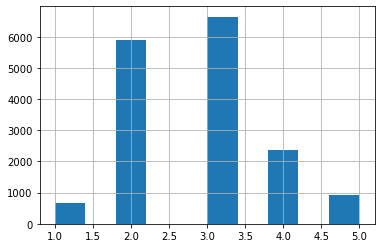

In [63]:
HouseData_preFeatures["income_cat"].hist()

In [64]:
HouseData_preFeatures["income_cat"].value_counts()

3    6648
2    5906
4    2375
5     934
1     654
Name: income_cat, dtype: int64

In [65]:
overall_bias = HouseData_preFeatures["income_cat"].value_counts() / len(HouseData_preFeatures)
overall_bias

3    0.402494
2    0.357571
4    0.143791
5    0.056548
1    0.039596
Name: income_cat, dtype: float64

## Using the earnings feature to find representative groups across random test set sample of entire population

In [28]:
random_train_set, random_test_set = train_test_split(HouseData_preFeatures, test_size=0.2, random_state=42)

In [29]:
random_test_set["income_cat"] = pd.cut(random_test_set.loc[:,"Earnings"],
 bins=[0, 15000, 30000, 45000, 60000, np.inf],
 labels=[1, 2, 3, 4, 5])
random_test_set["income_cat"].head(15)

<ipython-input-29-d0caf444492e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_test_set["income_cat"] = pd.cut(random_test_set.loc[:,"Earnings"],


1649     2
21063    2
12377    3
15016    3
11800    3
23587    3
30906    2
20704    2
27783    4
25785    2
9654     2
13522    2
4425     2
30563    3
2010     2
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

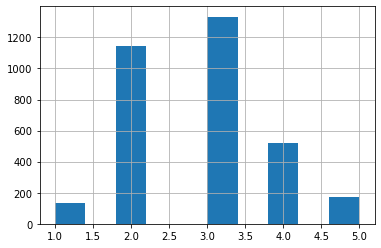

In [30]:
random_test_set["income_cat"].hist()

In [31]:
random_test_set["income_cat"].value_counts()

3    1333
2    1145
4     518
5     171
1     137
Name: income_cat, dtype: int64

In [33]:
random_test_bias = random_test_set["income_cat"].value_counts() / len(random_test_set)
random_test_bias

3    0.403450
2    0.346550
4    0.156780
5    0.051755
1    0.041465
Name: income_cat, dtype: float64

## Using the earnings feature to find representative groups across stratified test set sample of entire population

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(HouseData_preFeatures, HouseData_preFeatures["income_cat"]):
    strat_train_set = HouseData_preFeatures.iloc[train_index]
    strat_test_set = HouseData_preFeatures.iloc[test_index]

<AxesSubplot:>

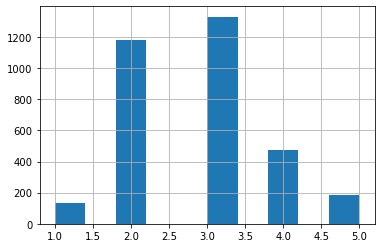

In [35]:
strat_test_set["income_cat"].hist()

In [36]:
strat_test_set["income_cat"].value_counts()

3    1330
2    1181
4     475
5     187
1     131
Name: income_cat, dtype: int64

In [70]:
strat_test_bias = strat_test_set["income_cat"].value_counts() / len(strat_test_set)
strat_test_bias

3    0.402542
2    0.357446
4    0.143765
5    0.056598
1    0.039649
Name: income_cat, dtype: float64

## Comparison of bias across sampling methods

In [38]:
table_bias = pd.DataFrame({'Overall':overall_bias,'Random':random_test_bias,'Stratified':strat_test_bias})
table_bias['Random_Error_Percent'] = (table_bias['Random'] - table_bias['Overall']) / table_bias['Overall'] * 100
table_bias['Stratified_Error_Percent'] = (table_bias['Stratified'] - table_bias['Overall']) / table_bias['Overall'] * 100
table_bias

Overall    Random  Stratified  Random_Error_Percent  \
3  0.402494  0.403450    0.402542              0.237510   
2  0.357571  0.346550    0.357446             -3.082283   
4  0.143791  0.156780    0.143765              9.032828   
5  0.056548  0.051755    0.056598             -8.474868   
1  0.039596  0.041465    0.039649              4.721041   

   Stratified_Error_Percent  
3                  0.011919  
2                 -0.035089  
4                 -0.018160  
5                  0.088887  
1                  0.134718

In [71]:
# Remove income category from training and test set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

C:\Users\gfann\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [72]:
HouseData_preFeatures = HouseData_preFeatures.drop(columns = 'income_cat')
HouseData_preFeatures.head(5)

Units                 GEO_ID  \
178  100.0  1500000US240338020021   
267  147.0  1500000US240253035021   
275  148.0  1500000US240253017024   
282  151.0  1500000US245101001003   
286  153.0  1500000US245102606042   

                                                  Name  Year  Population  \
178  Block Group 1, Census Tract 8020.02, Prince Ge...  2013       249.0   
267  Block Group 1, Census Tract 3035.02, Harford C...  2020       261.0   
275  Block Group 4, Census Tract 3017.02, Harford C...  2018       263.0   
282  Block Group 3, Census Tract 1001, Baltimore ci...  2016       261.0   
286  Block Group 2, Census Tract 2606.04, Baltimore...  2016       196.0   

     Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
178   21057.0     31.0       160.0    5.1      37.0       18.0  34.8   
267   51785.0      7.0        94.0    8.4      19.0       25.0  62.6   
275   15362.0     84.0       100.0    4.8      51.0       31.0  44.0   
282   21850.0     15.0       144.0    6.2      40.0       60.0  32.8   
286   24093.0     18.0        90.0    4.2      19.0       37.0  48.3   

     Transportation  HousePrice  School  Elders  
178            15.0    278800.0    85.0     9.0  
267             9.0    407400.0    43.0    87.0  
275            41.0    117000.0    13.0    54.0  
282             9.0     96400.0    67.0    30.0  
286            20.0     88300.0    76.0    52.0

# Exploratory Data Analysis

In [73]:
HouseData_preFeatures.describe()

Units    Population       Earnings       Poverty    Employment  \
count  16517.000000  16517.000000   16517.000000  16517.000000  16517.000000   
mean     696.108676   1619.947206   35372.152449     96.830114    889.716232   
std      365.479324    817.589468   15101.437560     96.029835    481.488634   
min      100.000000    108.000000    4095.000000      1.000000     44.000000   
25%      456.000000   1022.000000   25404.000000     34.000000    539.000000   
50%      619.000000   1463.000000   33177.000000     70.000000    793.000000   
75%      862.000000   2069.000000   42364.000000    129.000000   1152.000000   
max     5717.000000  13709.000000  241917.000000   1698.000000   5387.000000   

              Rooms      Children     HouseType           Age  Transportation  \
count  16517.000000  16517.000000  16517.000000  16517.000000    16517.000000   
mean       6.064915    193.530242     84.538536     39.954495       67.414664   
std        1.178421    129.750420    195.297441      8.197940       62.303695   
min        2.400000      2.000000      2.000000     15.200000        1.000000   
25%        5.300000    103.000000     31.000000     33.900000       25.000000   
50%        6.100000    164.000000     55.000000     39.300000       49.000000   
75%        6.900000    257.000000     95.000000     45.300000       90.000000   
max        8.500000   1625.000000   5355.000000     82.600000     1094.000000   

         HousePrice        School        Elders  
count  1.651700e+04  16517.000000  16517.000000  
mean   2.656668e+05    410.432827    222.538536  
std    1.343563e+05    302.236816    130.990993  
min    1.040000e+04      5.000000      4.000000  
25%    1.757000e+05    215.000000    131.000000  
50%    2.441000e+05    344.000000    200.000000  
75%    3.298000e+05    536.000000    285.000000  
max    1.714300e+06  12895.000000   1659.000000

In [74]:
#Shouldn't be more total homes than vacant homes.
HouseData_preFeatures.loc[HouseData_preFeatures['HouseType']>HouseData_preFeatures['Units']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [144]:
#Shouldn't be more total homes than vacant homes.
HouseData_preFeatures.loc[HouseData_preFeatures['Poverty']>HouseData_preFeatures['Population']]


Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders, house_per_person, working_per_person, poverty_per_person, child_per_person, elder_per_person, school_per_child, close_commute, vacancy_rate]
Index: []

[0 rows x 24 columns]

In [145]:
#Shouldn't be more employed people than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Employment']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders, house_per_person, working_per_person, poverty_per_person, child_per_person, elder_per_person, school_per_child, close_commute, vacancy_rate]
Index: []

[0 rows x 24 columns]

In [146]:
#Shouldn't be more people in school than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['School']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders, house_per_person, working_per_person, poverty_per_person, child_per_person, elder_per_person, school_per_child, close_commute, vacancy_rate]
Index: []

[0 rows x 24 columns]

In [147]:
#Shouldn't be more children than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Children']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders, house_per_person, working_per_person, poverty_per_person, child_per_person, elder_per_person, school_per_child, close_commute, vacancy_rate]
Index: []

[0 rows x 24 columns]

In [148]:
#Shouldn't be more people with a close commute than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Transportation']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders, house_per_person, working_per_person, poverty_per_person, child_per_person, elder_per_person, school_per_child, close_commute, vacancy_rate]
Index: []

[0 rows x 24 columns]

## Max of each variable

In [44]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Units']==HouseData_preFeatures['Units'].max()),:]

Units                 GEO_ID  \
31276  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
31276  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
31276   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
31276            91.0    342500.0   122.0   169.0

In [46]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Population']==HouseData_preFeatures['Population'].max()),:]

Units                 GEO_ID  \
28363  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
28363  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
28363    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
28363           729.0    338800.0  12895.0   129.0

In [47]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Earnings']==HouseData_preFeatures['Earnings'].max()),:]

Units                 GEO_ID  \
25045  843.0  1500000US240317056021   

                                                    Name  Year  Population  \
25045  Block Group 1, Census Tract 7056.02, Montgomer...  2020      1103.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
25045  241917.0     24.0       330.0    4.4      15.0       47.0  76.8   

       Transportation  HousePrice  School  Elders  
25045            13.0    960200.0    36.0   730.0

In [48]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Poverty']==HouseData_preFeatures['Poverty'].max()),:]

Units                 GEO_ID  \
30868  1567.0  1500000US240450105022   

                                                    Name  Year  Population  \
30868  Block Group 2, Census Tract 105.02, Wicomico C...  2014      4680.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
30868   10962.0   1698.0      1793.0    4.9     283.0      283.0  21.6   

       Transportation  HousePrice  School  Elders  
30868           566.0    170300.0  3228.0   180.0

In [49]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Rooms']==HouseData_preFeatures['Rooms'].max()),:]

Units                 GEO_ID  \
412     174.0  1500000US240253035021   
1427    246.0  1500000US245102801022   
2937    293.0  1500000US240054906032   
3128    297.0  1500000US245102715013   
3833    314.0  1500000US240054905001   
...       ...                    ...   
29942  1221.0  1500000US240317013071   
30531  1360.0  1500000US240338010042   
30576  1375.0  1500000US240317013071   
30750  1462.0  1500000US240178507131   
30821  1522.0  1500000US240098602002   

                                                    Name  Year  Population  \
412    Block Group 1, Census Tract 3035.02, Harford C...  2019       307.0   
1427   Block Group 2, Census Tract 2801.02, Baltimore...  2013       679.0   
2937   Block Group 2, Census Tract 4906.03, Baltimore...  2014       824.0   
3128   Block Group 3, Census Tract 2715.01, Baltimore...  2016       734.0   
3833   Block Group 1, Census Tract 4905, Baltimore Co...  2020       858.0   
...                                                  ...   ...         ...   
29942  Block Group 1, Census Tract 7013.07, Montgomer...  2013      3912.0   
30531  Block Group 2, Census Tract 8010.04, Prince Ge...  2019      4080.0   
30576  Block Group 1, Census Tract 7013.07, Montgomer...  2016      4357.0   
30750  Block Group 1, Census Tract 8507.13, Charles C...  2017      4336.0   
30821  Block Group 2, Census Tract 8602, Calvert Coun...  2020      4061.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
412     53570.0      6.0       107.0    8.5      18.0       28.0  64.4   
1427    16527.0      5.0       298.0    8.5      83.0       24.0  53.4   
2937    58403.0     11.0       476.0    8.5      92.0       20.0  46.4   
3128    61494.0     43.0       403.0    8.5      91.0        7.0  37.9   
3833   125185.0      8.0       432.0    8.5     132.0       30.0  46.3   
...         ...      ...         ...    ...       ...        ...   ...   
29942   58902.0    268.0      2081.0    8.5     489.0       36.0  38.7   
30531   44718.0     96.0      2285.0    8.5     539.0      189.0  40.9   
30576   59038.0    280.0      2437.0    8.5     605.0       29.0  42.9   
30750   41161.0    141.0      2355.0    8.5     666.0       74.0  35.9   
30821   51801.0     64.0      2467.0    8.5     430.0      111.0  44.4   

       Transportation  HousePrice  School  Elders  
412              20.0    446500.0    46.0   121.0  
1427             27.0    136000.0   193.0   166.0  
2937             24.0    465800.0   213.0   126.0  
3128             63.0    451300.0   103.0   102.0  
3833             32.0    685900.0   286.0   138.0  
...               ...         ...     ...     ...  
29942            75.0    569100.0  1495.0   417.0  
30531            55.0    372000.0  1192.0   380.0  
30576            96.0    586800.0  1423.0   500.0  
30750            50.0    342100.0  1295.0   302.0  
30821           377.0    524600.0  1011.0   674.0  

[63 rows x 16 columns]

In [50]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Children']==HouseData_preFeatures['Children'].max()),:]

Units                 GEO_ID  \
31209  2692.0  1500000US240317002051   

                                                    Name  Year  Population  \
31209  Block Group 1, Census Tract 7002.05, Montgomer...  2019      8987.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
31209   47975.0    255.0      4632.0    6.8    1625.0       18.0  33.7   

       Transportation  HousePrice  School  Elders  
31209            81.0    525300.0  3077.0   480.0

In [51]:
HouseData_preFeatures.loc[(HouseData_preFeatures['HouseType']==HouseData_preFeatures['HouseType'].max()),:]

Units                 GEO_ID  \
31274  5627.0  1500000US240479501002   
31276  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
31274  Block Group 2, Census Tract 9501, Worcester Co...  2020       480.0   
31276  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
31274  130696.0     22.0       286.0    3.4      12.0     5355.0  58.0   
31276   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
31274            52.0    381100.0    36.0   157.0  
31276            91.0    342500.0   122.0   169.0

In [52]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Age']==HouseData_preFeatures['Age'].max()),:]


Units                 GEO_ID  \
31099  1960.0  1500000US240317014201   

                                                    Name  Year  Population  \
31099  Block Group 1, Census Tract 7014.20, Montgomer...  2018      2851.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
31099   57206.0     16.0       608.0    4.2      67.0      193.0  82.6   

       Transportation  HousePrice  School  Elders  
31099            22.0    298800.0   267.0  1659.0

In [53]:
HouseData_preFeatures.loc[(HouseData_preFeatures['HousePrice']==HouseData_preFeatures['HousePrice'].max()),:]

Units                 GEO_ID  \
21829  716.0  1500000US240317048033   

                                                    Name  Year  Population  \
21829  Block Group 3, Census Tract 7048.03, Montgomer...  2019      1203.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
21829   49344.0     84.0       863.0    3.4     143.0       46.0  31.0   

       Transportation  HousePrice  School  Elders  
21829            40.0   1714300.0   375.0   113.0

In [54]:
HouseData_preFeatures.loc[(HouseData_preFeatures['School']==HouseData_preFeatures['School'].max()),:]

Units                 GEO_ID  \
28363  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
28363  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
28363    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
28363           729.0    338800.0  12895.0   129.0

In [55]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Elders']==HouseData_preFeatures['Elders'].max()),:]

Units                 GEO_ID  \
31099  1960.0  1500000US240317014201   

                                                    Name  Year  Population  \
31099  Block Group 1, Census Tract 7014.20, Montgomer...  2018      2851.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
31099   57206.0     16.0       608.0    4.2      67.0      193.0  82.6   

       Transportation  HousePrice  School  Elders  
31099            22.0    298800.0   267.0  1659.0

## Remove outlier

In [59]:
#University of Maryland campus
HouseData_preFeatures.loc[(HouseData_preFeatures['GEO_ID']=='1500000US240339800001'),:]

Units                 GEO_ID  \
28363  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
28363  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
28363    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
28363           729.0    338800.0  12895.0   129.0

In [91]:
#Salisbury University
HouseData_preFeatures.loc[(HouseData_preFeatures['GEO_ID']=='1500000US240450105022'),:]

Units                 GEO_ID  \
30786  1486.0  1500000US240450105022   
30868  1567.0  1500000US240450105022   
30901  1601.0  1500000US240450105022   
30914  1615.0  1500000US240450105022   
30940  1644.0  1500000US240450105022   
30974  1679.0  1500000US240450105022   

                                                    Name  Year  Population  \
30786  Block Group 2, Census Tract 105.02, Wicomico C...  2013      4293.0   
30868  Block Group 2, Census Tract 105.02, Wicomico C...  2014      4680.0   
30901  Block Group 2, Census Tract 105.02, Wicomico C...  2018      4966.0   
30914  Block Group 2, Census Tract 105.02, Wicomico C...  2015      4819.0   
30940  Block Group 2, Census Tract 105.02, Wicomico C...  2016      5010.0   
30974  Block Group 2, Census Tract 105.02, Wicomico C...  2017      5024.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
30786   12342.0   1450.0      1808.0    5.1     280.0      263.0  21.7   
30868   10962.0   1698.0      1793.0    4.9     283.0      283.0  21.6   
30901   12055.0   1098.0      2374.0    5.0     335.0      370.0  20.9   
30914   10812.0   1279.0      1799.0    4.8     301.0      336.0  21.6   
30940   10169.0   1184.0      2195.0    5.0     296.0      445.0  20.8   
30974   11668.0   1176.0      2520.0    5.0     235.0      418.0  21.1   

       Transportation  HousePrice  School  Elders  
30786           401.0    148600.0  2782.0   159.0  
30868           566.0    170300.0  3228.0   180.0  
30901          1070.0    189200.0  3494.0   172.0  
30914           604.0    173100.0  3231.0   197.0  
30940           823.0    195500.0  3610.0   171.0  
30974          1094.0    162500.0  3408.0   189.0

In [103]:
#Remove row containing outlier data involving University of Maryland Salisbury campuses. Also a major senior housing project area is removed.
#Used max of school,poverty, age, and elder variables to see how these rows stand out.

print(HouseData_preFeatures['Name'].notnull().sum())
HouseData_preFeatures= HouseData_preFeatures.loc[-(HouseData_preFeatures['GEO_ID'].isin(['1500000US240339800001','1500000US240450105022','1500000US240317014201'])),:]
print(HouseData_preFeatures['Name'].notnull().sum())

16510
16509


## Visualizations

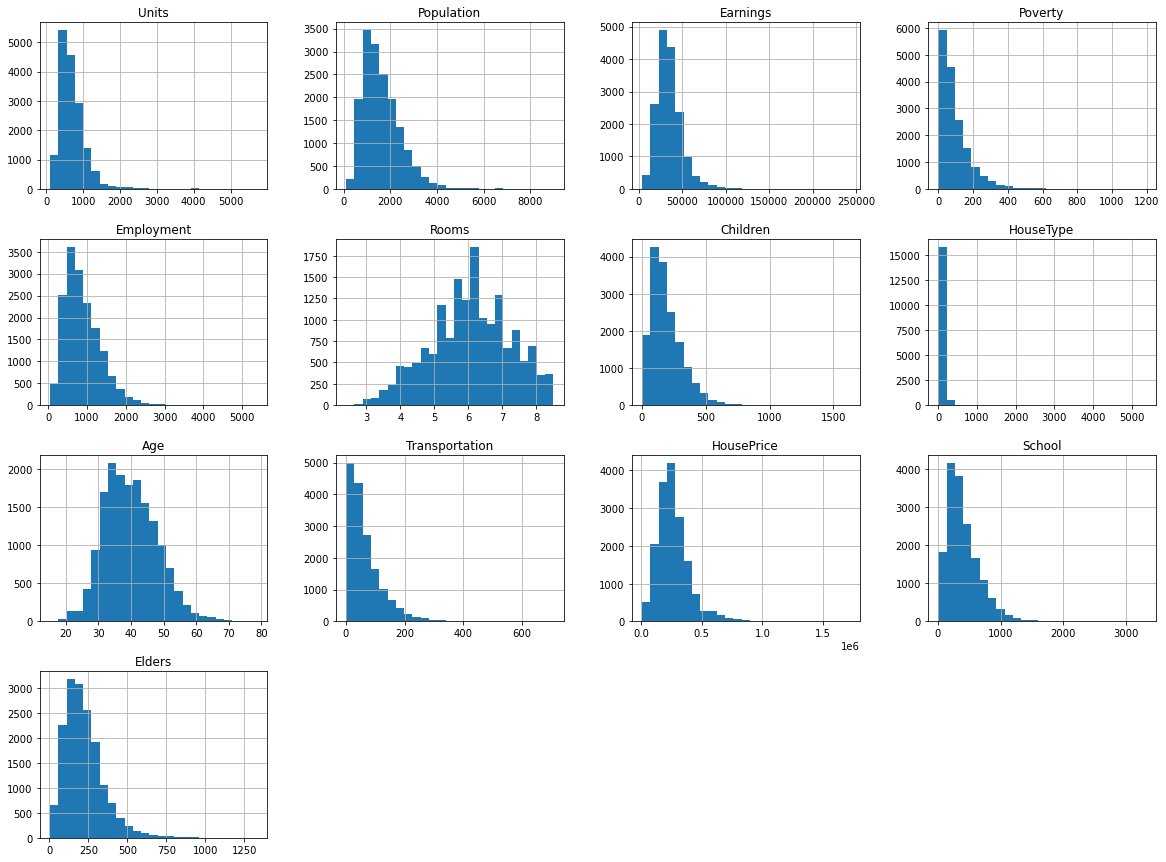

In [104]:
#Plot histograms of each variable
HouseData_preFeatures.hist(bins=25, figsize=(20,15))
plt.show()

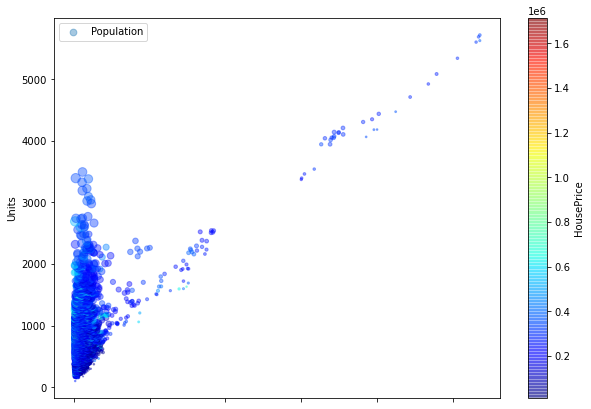

In [105]:
HouseData_preFeatures.plot(kind="scatter", x="HouseType", y="Units", alpha=0.4,
 s=HouseData_preFeatures["Population"]/100, label="Population", figsize=(10,7),
 c="HousePrice", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [143]:
# plotting both distibutions on the same figure
fig = sns.histplot(HouseData_preFeatures['Population'], kde =True, color = 'black')
fig = sns.histplot(HouseData_preFeatures['School'],kde =True, color = 'b')
fig = sns.histplot(HouseData_preFeatures['Elders'], kde =True, color = 'r')
fig = sns.histplot(HouseData_preFeatures['Children'], kde =True, color = 'y')
fig = sns.histplot(HouseData_preFeatures['Employment'],kde =True, color = 'c')
fig = sns.histplot(HouseData_preFeatures['Poverty'], kde =True, color = 'm')
fig = sns.histplot(HouseData_preFeatures['Transportation'], kde =True, color = 'g')

plt.xlim(0, 2000)
plt.xlabel('Units in feature')
plt.legend(labels = ['Population','School','Children','Employment','Poverty','Transportation'])
plt.show()




## Correlation

In [106]:
corr_matrix = HouseData_preFeatures.corr()
corr_matrix

Units  Population  Earnings   Poverty  Employment  \
Units           1.000000    0.749131  0.190522  0.232494    0.737427   
Population      0.749131    1.000000  0.086878  0.275176    0.949042   
Earnings        0.190522    0.086878  1.000000 -0.378239    0.185811   
Poverty         0.232494    0.275176 -0.378239  1.000000    0.205601   
Employment      0.737427    0.949042  0.185811  0.205601    1.000000   
Rooms          -0.178728    0.062319  0.250446 -0.376755    0.042557   
Children        0.614845    0.890205 -0.000632  0.227796    0.838299   
HouseType       0.554356   -0.016145  0.026216  0.038347   -0.030163   
Age            -0.017702   -0.225685  0.350057 -0.358902   -0.240647   
Transportation  0.388994    0.395842  0.012782  0.196253    0.382312   
HousePrice      0.142056    0.185643  0.733174 -0.260049    0.223804   
School          0.556534    0.863124 -0.040500  0.326484    0.792847   
Elders          0.596337    0.579476  0.264638  0.007632    0.484025   

                   Rooms  Children  HouseType       Age  Transportation  \
Units          -0.178728  0.614845   0.554356 -0.017702        0.388994   
Population      0.062319  0.890205  -0.016145 -0.225685        0.395842   
Earnings        0.250446 -0.000632   0.026216  0.350057        0.012782   
Poverty        -0.376755  0.227796   0.038347 -0.358902        0.196253   
Employment      0.042557  0.838299  -0.030163 -0.240647        0.382312   
Rooms           1.000000  0.083533  -0.153449  0.262146       -0.070493   
Children        0.083533  1.000000  -0.051033 -0.342402        0.310880   
HouseType      -0.153449 -0.051033   1.000000  0.114778        0.087813   
Age             0.262146 -0.342402   0.114778  1.000000       -0.099140   
Transportation -0.070493  0.310880   0.087813 -0.099140        1.000000   
HousePrice      0.308002  0.141323  -0.023735  0.211453        0.032780   
School          0.068180  0.825286  -0.043624 -0.413093        0.362724   
Elders          0.110491  0.349717   0.065523  0.403437        0.265868   

                HousePrice    School    Elders  
Units             0.142056  0.556534  0.596337  
Population        0.185643  0.863124  0.579476  
Earnings          0.733174 -0.040500  0.264638  
Poverty          -0.260049  0.326484  0.007632  
Employment        0.223804  0.792847  0.484025  
Rooms             0.308002  0.068180  0.110491  
Children          0.141323  0.825286  0.349717  
HouseType        -0.023735 -0.043624  0.065523  
Age               0.211453 -0.413093  0.403437  
Transportation    0.032780  0.362724  0.265868  
HousePrice        1.000000  0.138862  0.216777  
School            0.138862  1.000000  0.317806  
Elders            0.216777  0.317806  1.000000

In [107]:
corr_matrix['HousePrice'].sort_values(ascending = False)

HousePrice        1.000000
Earnings          0.733174
Rooms             0.308002
Employment        0.223804
Elders            0.216777
Age               0.211453
Population        0.185643
Units             0.142056
Children          0.141323
School            0.138862
Transportation    0.032780
HouseType        -0.023735
Poverty          -0.260049
Name: HousePrice, dtype: float64

In [108]:
#Correlation plot involving all current features
plt.figure(figsize = (15,8))
sns.heatmap(HouseData_preFeatures.corr())

<AxesSubplot:>

<Figure size 1080x576 with 0 Axes>

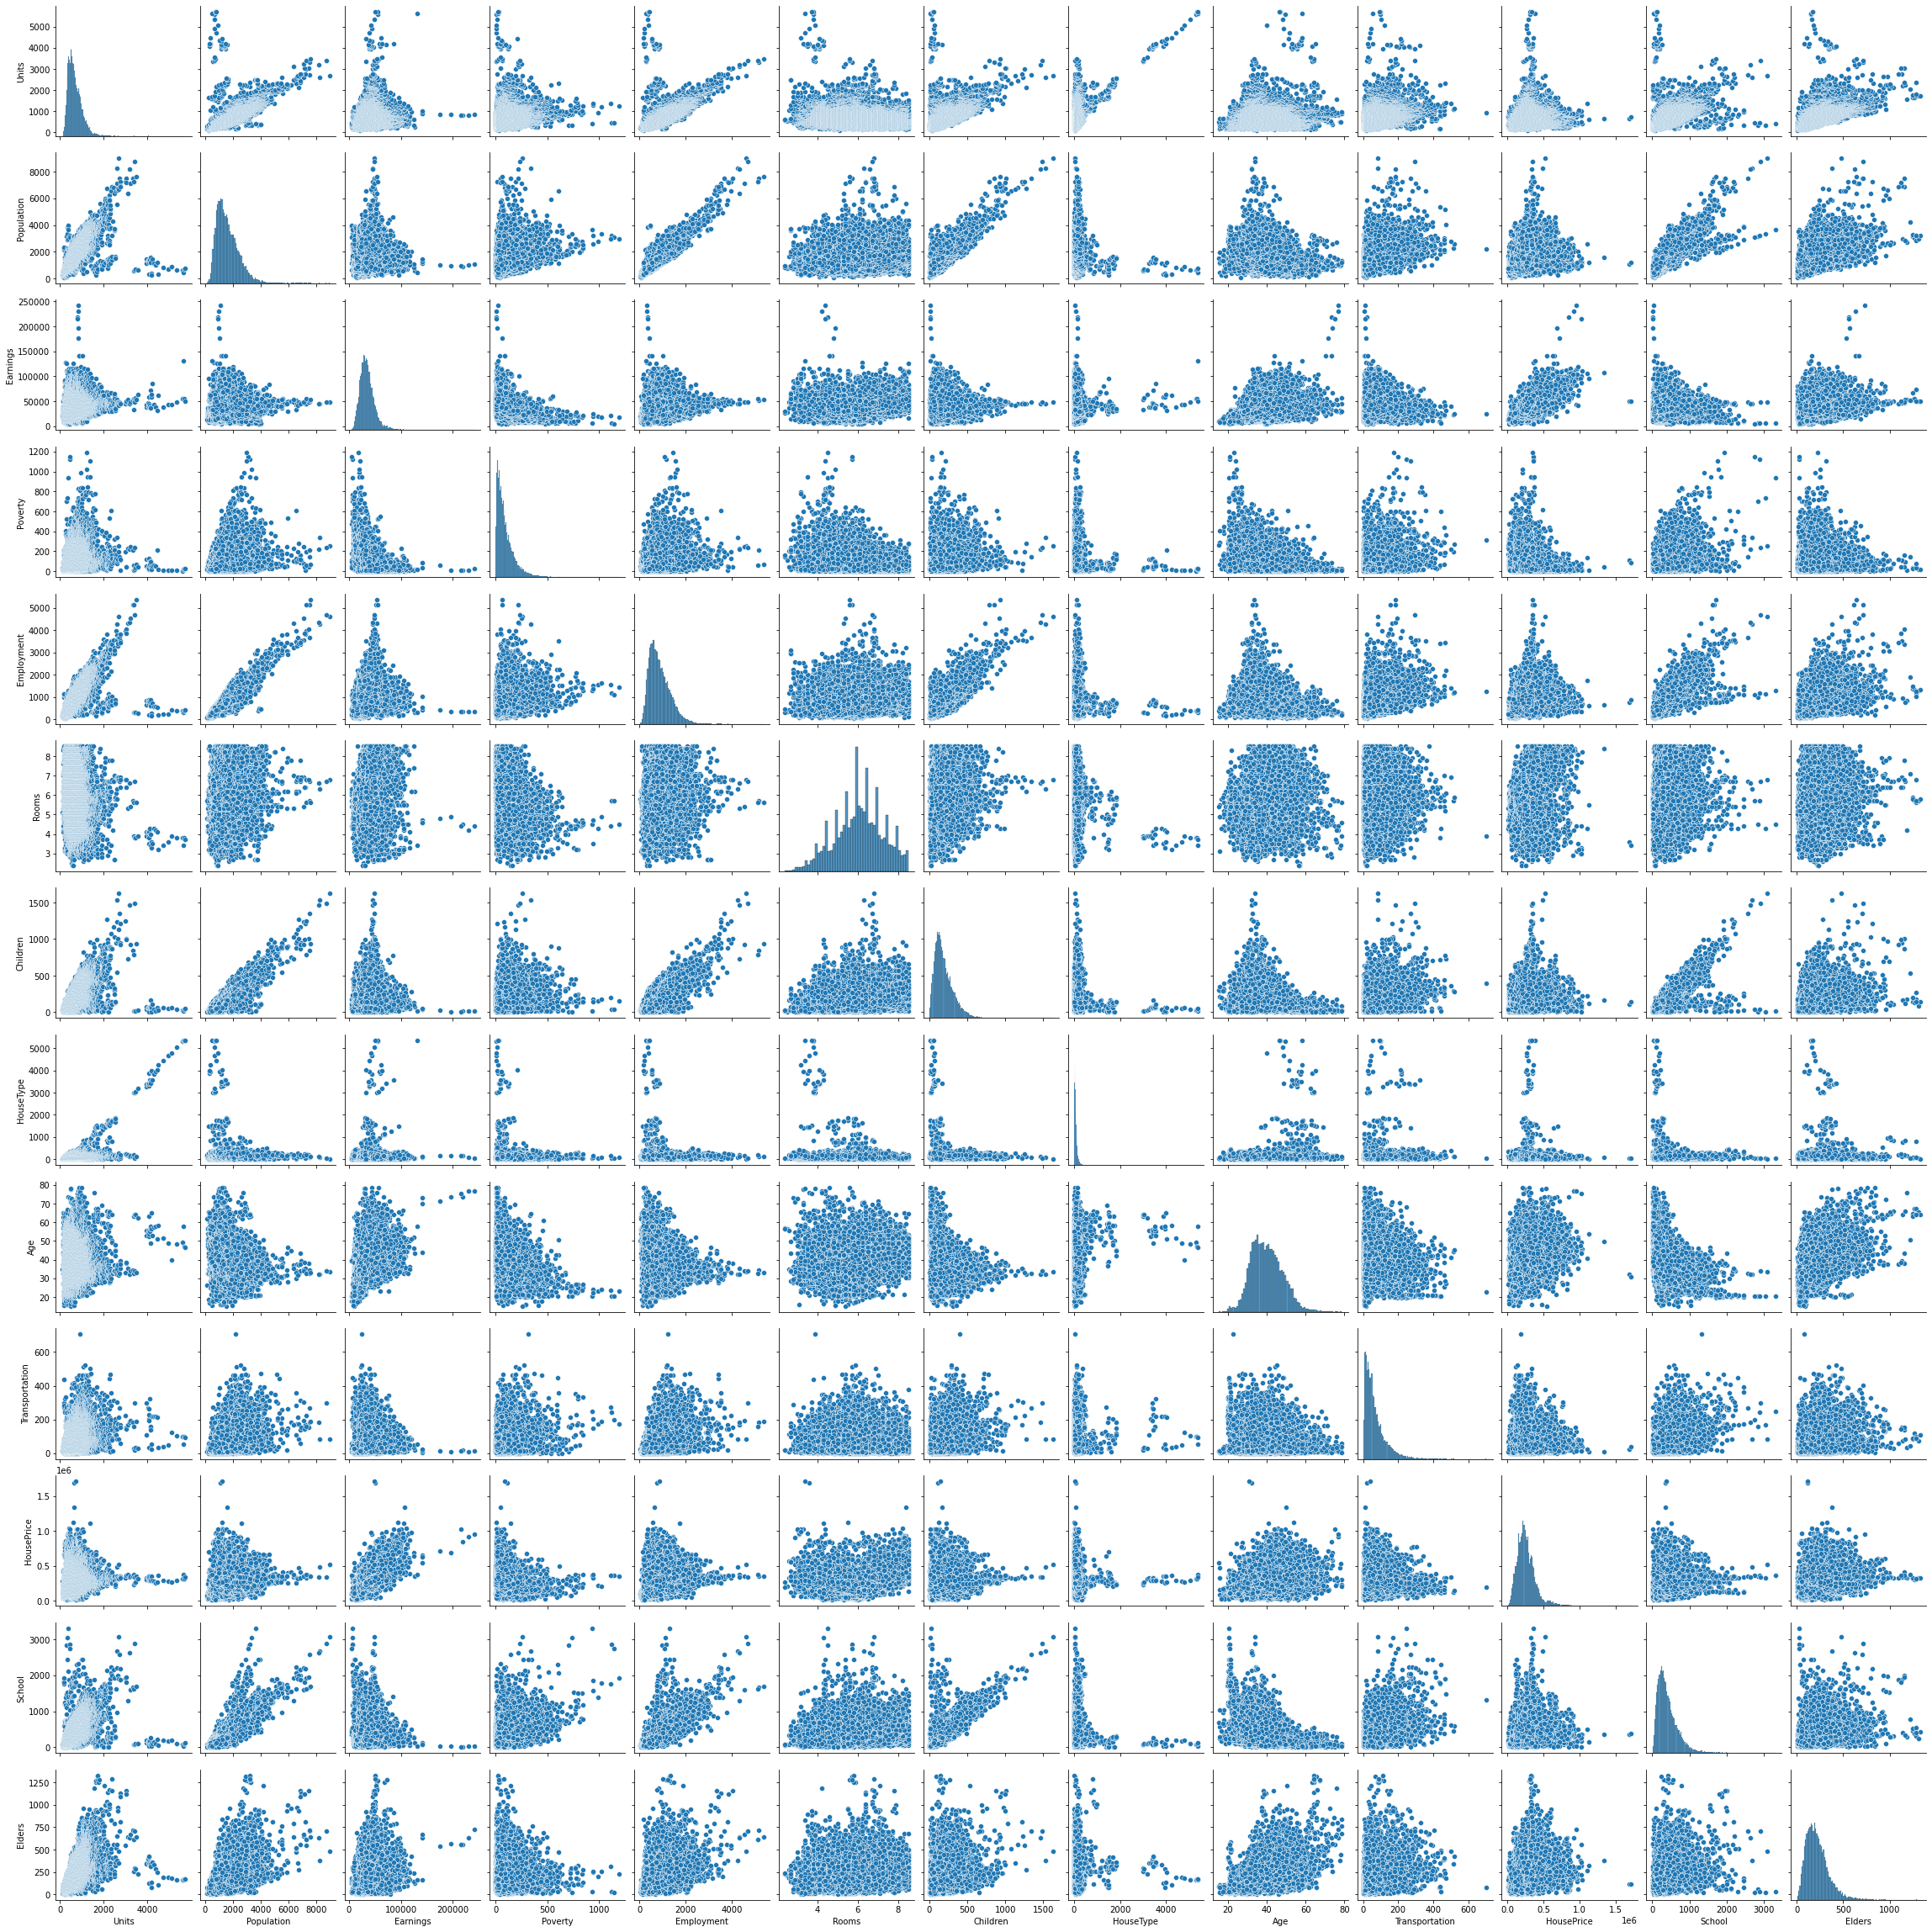

In [109]:
#Takes a minute to print all plots
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures)

<Figure size 1080x576 with 0 Axes>

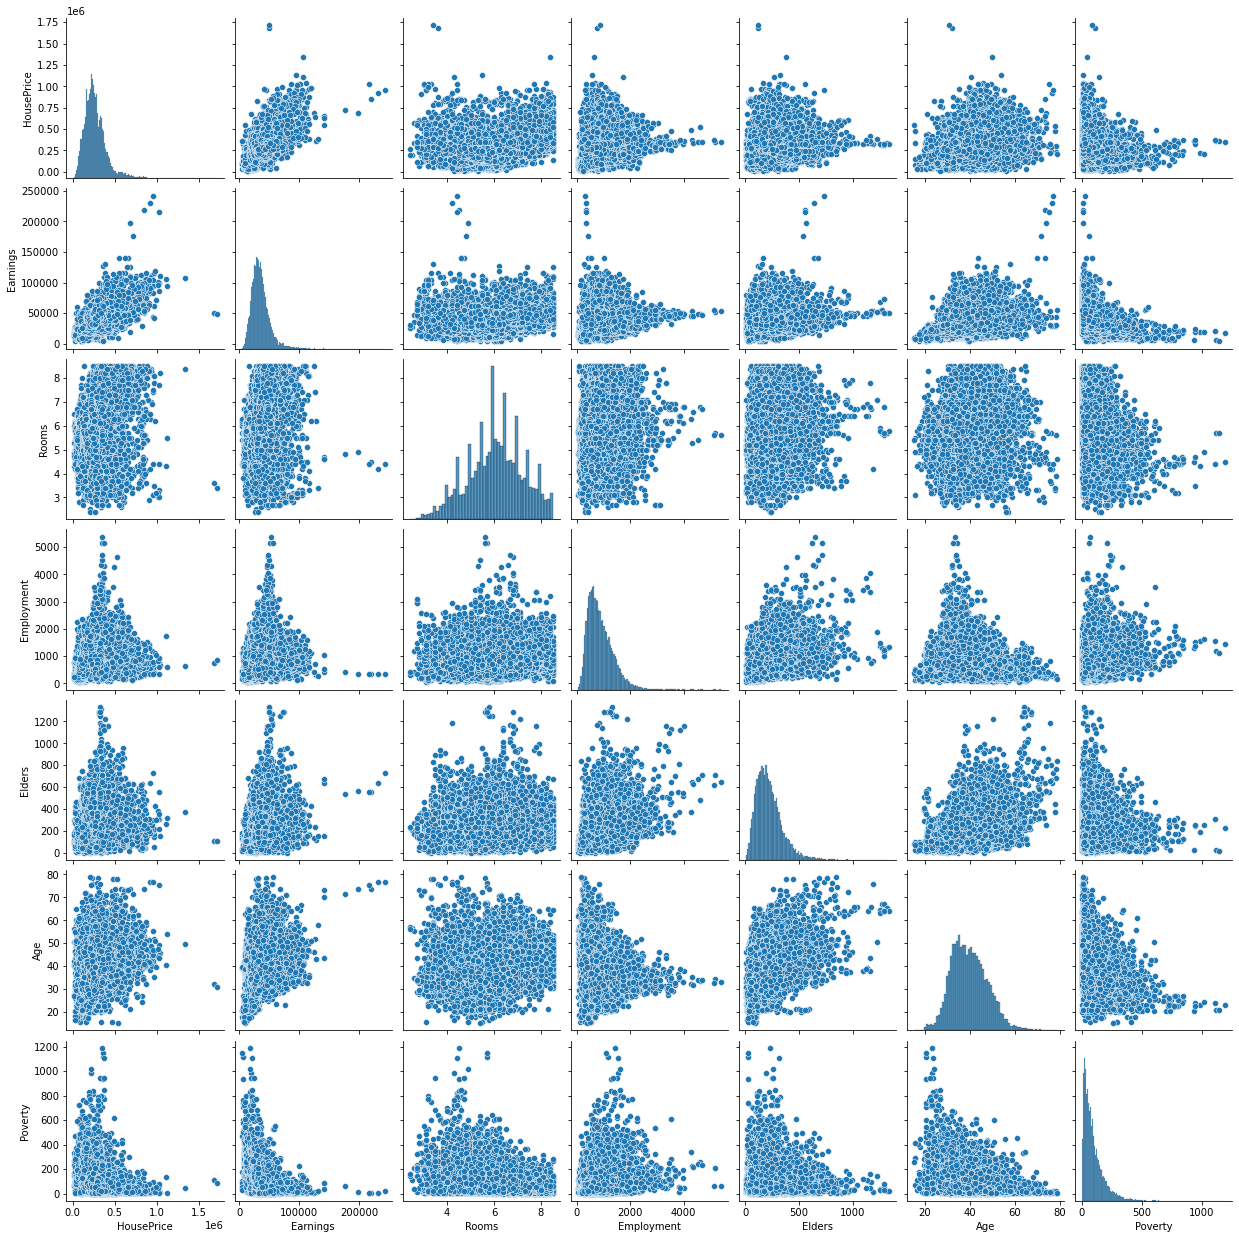

In [110]:
#Only looking at those with magnitude greater than .2 in correlation with target variable HousePrice
#HousePrice        1.000000
#Earnings          0.733174
#Rooms             0.308002
#Employment        0.223804
#Elders            0.216777
#Age               0.211453
#Poverty          -0.260049

list = ['HousePrice','Earnings','Rooms','Employment','Elders','Age','Poverty']
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures[list])

## New Attribute combinations

In [137]:
HouseData_preFeatures['house_per_person'] = HouseData_preFeatures['Units'] / HouseData_preFeatures['Population']
HouseData_preFeatures['working_per_person'] = HouseData_preFeatures['Employment'] / HouseData_preFeatures['Population']
HouseData_preFeatures['poverty_per_person'] = HouseData_preFeatures['Poverty'] / HouseData_preFeatures['Population']
HouseData_preFeatures['child_per_person'] = HouseData_preFeatures['Children'] / HouseData_preFeatures['Population']
HouseData_preFeatures['elder_per_person'] = HouseData_preFeatures['Elders'] / HouseData_preFeatures['Population']
HouseData_preFeatures['school_per_child'] = HouseData_preFeatures['School'] / HouseData_preFeatures['Children']
HouseData_preFeatures['close_commute'] = HouseData_preFeatures['Transportation'] / HouseData_preFeatures['Employment']
HouseData_preFeatures['vacancy_rate'] = HouseData_preFeatures['HouseType'] / HouseData_preFeatures['Units']
# Considered adding a yearly variable to account for a trend, but there may not be a constant increasing trend
# Earnings variable should help cover rises and falls in housing prices year to year due to inflation and larger macroeconomic trends


<ipython-input-137-16a2461696d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HouseData_preFeatures['house_per_person'] = HouseData_preFeatures['Units'] / HouseData_preFeatures['Population']
<ipython-input-137-16a2461696d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HouseData_preFeatures['working_per_person'] = HouseData_preFeatures['Employment'] / HouseData_preFeatures['Population']
<ipython-input-137-16a2461696d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [138]:
corr_matrix = HouseData_preFeatures.corr()
corr_matrix['HousePrice'].sort_values(ascending = False)

HousePrice            1.000000
Earnings              0.733174
Rooms                 0.308002
Employment            0.223804
Elders                0.216777
Age                   0.211453
working_per_person    0.203669
Population            0.185643
Units                 0.142056
Children              0.141323
School                0.138862
elder_per_person      0.077274
Transportation        0.032780
school_per_child     -0.003060
child_per_person     -0.009126
house_per_person     -0.022702
HouseType            -0.023735
close_commute        -0.110475
vacancy_rate         -0.224732
Poverty              -0.260049
poverty_per_person   -0.391623
Name: HousePrice, dtype: float64

In [158]:
corr_matrix.loc[((corr_matrix['HousePrice']>.2) | (corr_matrix['HousePrice']<-.2)),'HousePrice'].sort_values(ascending = False)

HousePrice            1.000000
Earnings              0.733174
Rooms                 0.308002
Employment            0.223804
Elders                0.216777
Age                   0.211453
working_per_person    0.203669
vacancy_rate         -0.224732
Poverty              -0.260049
poverty_per_person   -0.391623
Name: HousePrice, dtype: float64

In [123]:
#Only looking at those with magnitude greater than .2 in correlation with target variable HousePrice
#HousePrice            1.000000
#Earnings              0.733174
#Rooms                 0.308002
#Employment            0.223804
#Elders                0.216777
#Age                   0.211453
#working_per_person    0.203669
#vacancy_rate         -0.224732
#Poverty              -0.260049
#poverty_per_person   -0.391623

list = ['HousePrice','Earnings','Rooms','Employment','Elders','Age','working_per_person','vacancy_rate','Poverty','poverty_per_person']
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures[list])

<Figure size 1080x576 with 0 Axes>

# Training Preparation

## Split response out and narrow potential feature list down

In [151]:
response = HouseData_preFeatures[['HousePrice']]

#Selecting those with correlation above .1 and not highly correlated with other features. Trying to avoid straight nominal variables like population
pre_training_features = HouseData_preFeatures[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]

## Standardize potential features

In [172]:
scaler_s = StandardScaler()

pre_training_features_standardized = scaler_s.fit_transform(pre_training_features)
names = pre_training_features.columns
pre_training_features_standardized = pd.DataFrame(pre_training_features_standardized, columns = names)
pre_training_features_standardized

Earnings     Rooms       Age  working_per_person  close_commute  \
0     -0.948949 -0.819323 -0.630511            1.021578       0.152635   
1      1.086696  1.981134  2.766480           -1.971051       0.180769   
2     -1.326227 -1.073910  0.493673           -1.758328       4.613262   
3     -0.896415  0.114162 -0.874898            0.058928      -0.288139   
4     -0.747822 -1.583084  1.019107           -0.921676       1.964703   
...         ...       ...       ...                 ...            ...   
16504  0.828729 -1.922534  1.019107           -0.062144       2.882508   
16505  1.357051 -1.922534  1.141301            0.157760       2.599352   
16506  6.314332 -2.261983  2.204388            0.526331       1.394814   
16507  1.335388 -1.922534  0.860255           -0.030034       2.329721   
16508  1.012234 -2.007396  0.811377            0.082881       1.808347   

       vacancy_rate  poverty_per_person  
0          0.585793            0.914095  
1          0.491682           -0.634578  
2          0.864937            4.004107  
3          2.645307           -0.148605  
4          1.171665            0.396255  
...             ...                 ...  
16504      7.857197           -0.823164  
16505      7.853450           -0.961783  
16506      7.897690           -0.333123  
16507      7.774330           -0.449163  
16508      7.755732           -0.550329  

[16509 rows x 7 columns]

## Normalize potential features

In [173]:
scaler_n = MinMaxScaler()

pre_training_features_normalized = scaler_n.fit_transform(pre_training_features)
names = pre_training_features.columns
pre_training_features_normalized = pd.DataFrame(pre_training_features_normalized, columns = names)
pre_training_features_normalized

Earnings     Rooms       Age  working_per_person  close_commute  \
0      0.071322  0.442623  0.308661            0.661612       0.129344   
1      0.200528  0.983607  0.746457            0.319584       0.132119   
2      0.047376  0.393443  0.453543            0.343896       0.569314   
3      0.074657  0.622951  0.277165            0.551590       0.085869   
4      0.084088  0.295082  0.521260            0.439517       0.308076   
...         ...       ...       ...                 ...            ...   
16504  0.184155  0.229508  0.521260            0.537753       0.398603   
16505  0.217688  0.229508  0.537008            0.562886       0.370674   
16506  0.532335  0.163934  0.674016            0.605010       0.251865   
16507  0.216313  0.229508  0.500787            0.541423       0.344079   
16508  0.195802  0.213115  0.494488            0.554328       0.292654   

       vacancy_rate  poverty_per_person  
0          0.185492            0.235186  
1          0.175070            0.050008  
2          0.216403            0.604665  
3          0.413555            0.108116  
4          0.250369            0.173267  
...             ...                 ...  
16504      0.990700            0.027458  
16505      0.990285            0.010883  
16506      0.995184            0.086053  
16507      0.981523            0.072178  
16508      0.979464            0.060081  

[16509 rows x 7 columns]

## Linear Regression to see significance of potential features

In [178]:
response = response.reset_index().drop(columns = {'index'})
OLS(response,pre_training_features_standardized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             HousePrice   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):              0.117
Method:                 Least Squares   F-statistic:                              313.5
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:39:26   Log-Likelihood:                     -2.3047e+05
No. Observations:               16509   AIC:                                  4.610e+05
Df Residuals:                   16502   BIC:                                  4.610e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Earnings            1.018e+05   2780.866     36.610      0.000    9.64e+04    1.07e+05
Rooms               1.502e+04   2464.177      6.094      0.000    1.02e+04    1.98e+04
Age                -1.337e+04   2532.266     -5.281      0.000   -1.83e+04   -8408.704
working_per_person -1.715e+04   2551.950     -6.722      0.000   -2.22e+04   -1.22e+04
close_commute       -238.0205   2262.818     -0.105      0.916   -4673.388    4197.347
vacancy_rate       -1.082e+04   2387.486     -4.532      0.000   -1.55e+04   -6140.245
poverty_per_person -5195.3986   2681.123     -1.938      0.053   -1.05e+04      59.891
==============================================================================
Omnibus:                     6304.751   Durbin-Watson:                   0.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100751.387
Skew:                           1.406   Prob(JB):                         0.00
Kurtosis:                      14.771   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
response = response.reset_index().drop(columns = {'index'})
OLS(response,pre_training_features_normalized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             HousePrice   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                          2.389e+04
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:42:08   Log-Likelihood:                     -2.1161e+05
No. Observations:               16509   AIC:                                  4.232e+05
Df Residuals:                   16502   BIC:                                  4.233e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Earnings            1.577e+06   1.39e+04    113.146      0.000    1.55e+06     1.6e+06
Rooms               1.302e+05   3507.811     37.105      0.000    1.23e+05    1.37e+05
Age                -4.065e+04   5755.012     -7.063      0.000   -5.19e+04   -2.94e+04
working_per_person -1.127e+04   4572.253     -2.464      0.014   -2.02e+04   -2304.326
close_commute       3.085e+04   7200.264      4.284      0.000    1.67e+04     4.5e+04
vacancy_rate       -7.229e+04   6804.417    -10.624      0.000   -8.56e+04    -5.9e+04
poverty_per_person  4.087e+04   6336.853      6.450      0.000    2.85e+04    5.33e+04
==============================================================================
Omnibus:                     6278.593   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91407.109
Skew:                           1.427   Prob(JB):                         0.00
Kurtosis:                      14.169   Cond. No.                         19.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Feature Selection and Create Training/Test Set

In [ ]:
# Keep those recently scaled variables in as they appear to be significant and correlated enough to justify keeping them

In [186]:
#Split data in pre-scaled set into housing info and final features to be used. Will be rejoined for analysis purposes later
housing_info_train = strat_train_set[['GEO_ID','Name','Year']]
strat_train_set['working_per_person'] = strat_train_set['Employment'] / strat_train_set['Population']
strat_train_set['poverty_per_person'] = strat_train_set['Poverty'] / strat_train_set['Population']
strat_train_set['close_commute'] = strat_train_set['Transportation'] / strat_train_set['Employment']
strat_train_set['vacancy_rate'] = strat_train_set['HouseType'] / strat_train_set['Units']
X_train = strat_train_set[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]
y_train = strat_train_set[['HousePrice']]

<ipython-input-186-3b175be28989>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set['working_per_person'] = strat_train_set['Employment'] / strat_train_set['Population']
<ipython-input-186-3b175be28989>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set['poverty_per_person'] = strat_train_set['Poverty'] / strat_train_set['Population']
<ipython-input-186-3b175be28989>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [187]:
housing_info_test = strat_test_set[['GEO_ID','Name','Year']]
strat_test_set['working_per_person'] = strat_test_set['Employment'] / strat_test_set['Population']
strat_test_set['poverty_per_person'] = strat_test_set['Poverty'] / strat_test_set['Population']
strat_test_set['close_commute'] = strat_test_set['Transportation'] / strat_test_set['Employment']
strat_test_set['vacancy_rate'] = strat_test_set['HouseType'] / strat_test_set['Units']
X_test = strat_test_set[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]
y_test = strat_test_set[['HousePrice']]

<ipython-input-187-5ca9b3eb3f57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set['working_per_person'] = strat_test_set['Employment'] / strat_test_set['Population']
<ipython-input-187-5ca9b3eb3f57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set['poverty_per_person'] = strat_test_set['Poverty'] / strat_test_set['Population']
<ipython-input-187-5ca9b3eb3f57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

# Scale the training and test set